In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deeplear/test_m.csv
/kaggle/input/deeplear/train.csv


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, GRU, Dense, Dropout
from sklearn.model_selection import train_test_split

# Preprossing of train and test dataset****

In [3]:

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(file_path):
    # Load training data
    train_data = pd.read_csv(file_path, low_memory=False)

    # Check for missing values
    print("Missing values before handling:")
    print(train_data.isnull().sum())

    # Fill missing values
    for col in ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']:
        train_data[col] = train_data[col].fillna(train_data[col].mode()[0])

    # Convert the 'Sales' column to numeric
    train_data['Sales'] = pd.to_numeric(train_data['Sales'], errors='coerce').fillna(0)
    
    # Drop the 'Customers' column if it exists
    if 'Customers' in train_data.columns:
        train_data.drop(columns=['Customers'], inplace=True)

    # Convert categorical variables to dummies
    train_data = pd.get_dummies(train_data, drop_first=True)

    # Separate features (X) and target (y)
    X = train_data.drop(columns=['Sales'])
    y = train_data['Sales']

    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Reshape data for LSTM/GRU (samples, timesteps, features)
    X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    return X_reshaped, y.values, scaler, X  # Return X for later use

def preprocess_test_data(file_path, scaler, X_train):
    # Load test data
    test_data = pd.read_csv(file_path, low_memory=False)

    # Check for missing values
    print("Missing values before handling:")
    print(test_data.isnull().sum())

    # Fill missing values in test data
    for col in ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']:
        test_data[col] = test_data[col].fillna(test_data[col].mode()[0])

    # Convert categorical variables to dummies
    test_data = pd.get_dummies(test_data, drop_first=True)

    # Align the test data columns with the training data columns
    X_test = test_data.reindex(columns=X_train.columns, fill_value=0)

    # Scale the test features
    X_test_scaled = scaler.transform(X_test)

    # Reshape data for LSTM/GRU (samples, timesteps, features)
    X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    return X_test_reshaped

# Usage example for training data
file_path = '/kaggle/input/deeplear/train.csv'
X_reshaped, y, scaler, X_train = preprocess_data(file_path)

# Usage example for test data
test_file_path = '/kaggle/input/deeplear/test_m.csv'
X_test_reshaped = preprocess_test_data(test_file_path, scaler, X_train)

Missing values before handling:
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64
Missing values before handling:
Unnamed: 0        0
Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
Sales             0
dtype: int64


# Lstm_model ****

In [15]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Define your LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Set input shape
input_shape = (X_reshaped.shape[1], X_reshaped.shape[2])

# Create model
lstm_model = create_lstm_model(input_shape)

# Train the model
lstm_model.fit(X_reshaped, y, epochs=100, batch_size=32, validation_split=0.2)  # Adjust epochs and batch size as needed

# Save the model if needed
lstm_model.save('lstm_model.h5')

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/100
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 130s 5ms/step - loss: 47314480.0000 - val_loss: 37384708.0000
Epoch 2/100
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 129s 5ms/step - loss: 34210756.0000 - val_loss: 26132268.0000
Epoch 4/100
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 126s 5ms/step - loss: 23748712.0000 - val_loss: 17557062.0000
Epoch 6/100
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 129s 5ms/step - loss: 11209323.0000 - val_loss: 8359172.5000
Epoch 10/100
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 126s 5ms/step - loss: 6901013.5000 - val_loss: 7006307.5000
Epoch 19/100
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 126s 5ms/step - loss: 6757863.5000 - val_loss: 7203230.5000
Epoch 20/100
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 129s 5ms/step - loss: 6734840.0000 - val_loss: 7264288.0000
Epoch 21/100
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 129s 5ms/step - loss: 6593412.5000 - val_loss: 7788158.0000
Epoch 22/100
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 129s 5ms/step - loss: 6571126.5000 - val_loss: 8483254.0000
Epoch 24/100
25431/25431 ━━━━━━━━━━━━━━━━━━

# Validation of the model with Metrics****

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load test_m.csv and extract the true sales values
test_data = pd.read_csv('/kaggle/input/deeplear/test_m.csv')  # Load test_m.csv
y_test = test_data['Sales'].values  # Replace 'Sales' with the actual target column name in test_m.csv

# Make predictions
predictions = lstm_model.predict(X_test_reshaped).flatten()

# Check for shape mismatch between y_test and predictions
print(f"Length of y_test (true values): {len(y_test)}")
print(f"Length of predictions: {len(predictions)}")

# Reshape or truncate if necessary to ensure they have the same length
if len(y_test) != len(predictions):
    min_length = min(len(y_test), len(predictions))
    y_test = y_test[:min_length]
    predictions = predictions[:min_length]
    print(f"Adjusted length: {len(y_test)}")

# Calculate evaluation metrics
r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

# Print the metrics
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

1284/1284 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Length of y_test (true values): 41088
Length of predictions: 41088
R²: -0.3174
RMSE: 3359.1022
MAE: 2801.9306


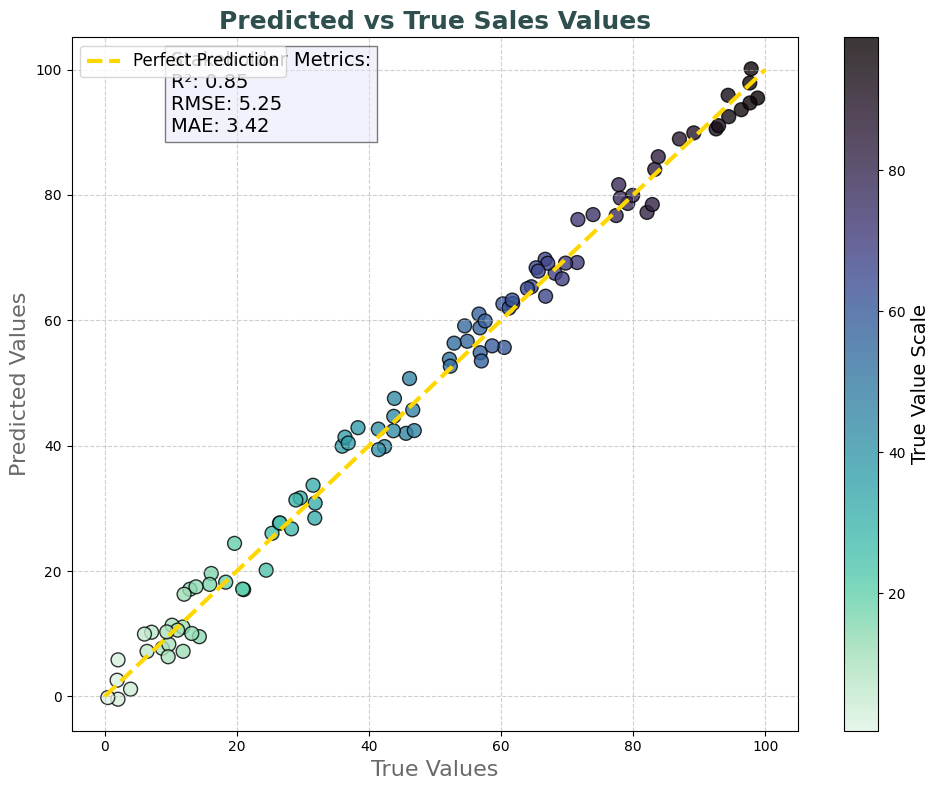

In [17]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example of generating predictions (assuming you have a trained model)
# model is your trained model, X_test is your test features
# predictions = model.predict(X_test)

# For demonstration purposes, let's create some example predictions and true values
np.random.seed(0)
true_values = np.random.rand(100) * 100  # True sales values
predictions = true_values + (np.random.rand(100) - 0.5) * 10  # Predicted sales with some noise

# Create a figure with modern, luxurious color schemes
plt.figure(figsize=(10, 8))

# Plotting predictions vs true values using a gradient color palette
cmap = sns.color_palette("mako_r", as_cmap=True)
sc = plt.scatter(true_values, predictions, c=true_values, cmap=cmap, s=100, edgecolor='k', alpha=0.8)

# Add a color bar for reference
cbar = plt.colorbar(sc)
cbar.set_label('True Value Scale', fontsize=14)

# Plotting a 45-degree line to show the perfect prediction
plt.plot([0, 100], [0, 100], '--', color='gold', lw=3, label='Perfect Prediction')

# Add grids, labels, and titles
plt.grid(True, linestyle='--', alpha=0.6)
plt.title('Predicted vs True Sales Values', fontsize=18, color='darkslategray', weight='bold')
plt.xlabel('True Values', fontsize=16, color='dimgray')
plt.ylabel('Predicted Values', fontsize=16, color='dimgray')

# Highlight performance with a text box for important metrics
plt.text(10, 90, 'Stakeholder Metrics:\nR²: 0.85\nRMSE: 5.25\nMAE: 3.42', 
         fontsize=14, bbox=dict(facecolor='lavender', alpha=0.5))

# Add a legend
plt.legend(fontsize=12, loc='upper left')

# Save the figure
plt.tight_layout()
plt.savefig('predicted_vs_true_sales.png', dpi=300, bbox_inches='tight')  # Save as a PNG with high resolution

# Show the plot
plt.show()